# HW-2: 

* Classification and regression are some of the most common forms of supervised machine learning 
* In this homework we will explore regression and multi-class classification, as applied to text data
* I would recommend starting the data collection and prep ASAP. Then doing the Neural network training after you have completed the labs.
* Once the data is collected, this HW should be quite easy, since most of the code can be recycled from the labs and textbook. 
* **You can do this assignment in either Keras OR Pytorch. It is your choice.** 

**Instructions** 
* **Develope a text based classification and regression data-set:**
  * Use the wikipedia API to search for articles to generate the data-set
  * Select a set of highly different topics (i.e. labels), for example, 
    * multi-class case: y=(pizza, oak_trees, joe_biden, ... , etc)=(0,1,2, ... , N-1)
    * You don't have to use these, you can use whatever labels you want but use at least 3 labels.  
  * Search for wikipedia pages about these topics and harvest the text from the pages. 
  * Do some basic text cleaning as needed. 
  * Use the NLTK sentence tokenizer to break the text into sentences. Then form chunks of text that are five sentences long as your "inputs".
  * The "label" for these chunks will be the search label used to find the text. 
  * Also "tag" each chunk of text with an associated "compound" sentiment score computed using NLTK sentiment analysis.
  * The data set will not be perfect. 
    * There will be chunks of text that are not related to the topic (i.e. noise). 
    * However that is just something we have to live with.

  * Important: Start small when writing and debugging THEN scale up. The more chunks of text you have the better.
  * Do this in a file called "data_collection.ipynb", have it save its results to a folder "data"
    * Save the text and labels to the same format used by the textbook, that way you can recycle your lab code seamlessly. 
    * Also, include a second file with the associated numeric sentiment scores.
* **Training guide-lines**
  * Do the training in this "HW-2.ipynb" file
  * Use a dense feed forward ANN model
  * Normalize the data as needed
  * Visualize the results at the end where possible
  * Partition data into training, validation, and test
  * Monitor training and validation throughout training by plotting
  * Print training, validation, and test errors at the very end
  * Do basic hyper parameter tuning to try to achieve an optimal fit model
    * i.e. best training/validation loss without over-fitting
    * Explore L1 and L2 regularization (or dropout)
    * Explore different optimizers 
    * Use the loss functions specified in the textbook
    * Explore different options for activation functions, network size/depth, etc
  * **Document what is going on in the code, as needed, with narrative markdown text between cells.**
  * *Submit the version with hyper parameters that provide the optimal fit*
    * i.e. you don't need to show the outputs of your hyper-parameter tuning process
  * *Optional*: write an outer loop to do an automated hyperparameter search.
* **Classification training:**
  * Recycle your code from lab-2.2 to train a multi-class classifier on the data set 
* **Regression training:**
  * Use your lab-2.1 code as a starting point 
  * Train a ANN to predict the sentiment score from the vectorized text
    * Use the same input matrix as the classification problem
    * This is a bit of a silly and circular exercise, since we are using the outputs of the NLTK model to train an ANN model.
    * The only time you would want to do this is if the second model is computationally MUCH MUCH faster than the first.
    * That being said, it is an educational exercise so hopefully it is informative.   
  
**Submission:**
* You need to upload TWO documents to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of the "HW-2.ipynb" document 
  * (2) A PDF (or HTML) of the completed form of the "data_collection.ipynb" document 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc
* **Total points:** 41.66


In [1]:
import pandas as pd
data = pd.read_csv('data.csv')
data_w_score = pd.read_csv('data_w_score.csv')

In [10]:
all_inputs = data['content']
all_labels = data['label']

In [9]:
import pandas as pd
import tensorflow as tf

In [11]:
from sklearn.model_selection import train_test_split
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(all_inputs, all_labels, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24,) (6,) (24,) (6,)


In [12]:
# Train Data Labels
y_train = y_train.astype('category')
y_train = y_train.cat.codes
train_features, train_labels = X_train, tf.one_hot(
    y_train, 6)

2022-10-03 22:17:16.467033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Test Data Labels
y_test = y_test.astype('category')
y_test = y_test.cat.codes
test_features, test_labels = X_test, tf.one_hot(
    y_test, 6)

In [14]:
import nltk
from nltk.tokenize import word_tokenize

tokenized_train_features = [word_tokenize(each_train_text) for each_train_text in train_features]
tokenized_test_features = [word_tokenize(each_test_text) for each_test_text in test_features]

In [16]:
import gensim
from gensim.models import word2vec

#config
vector_size = 300

w2v_model = word2vec.Word2Vec(
    tokenized_train_features,
    vector_size=vector_size,  # Dimensionality of the word vectors
    window=20,
    min_count=1,
    sg=1  # 1 for skip-gram; otherwise CBOW
)

In [17]:
vocab_list = list(w2v_model.wv.key_to_index.keys())

def remove_OOV_vocab(sample: list, list_vocab):
   
    in_vocab_sample = []
    for each_token in sample:
        if each_token in list_vocab:
            in_vocab_sample.append(each_token)
    return in_vocab_sample
  
tokenized_test_features = [remove_OOV_vocab(each_test_sample, vocab_list) for each_test_sample in tokenized_test_features]


In [21]:
# Get the embedding matrix

vocab = w2v_model.wv.key_to_index.keys()
embedding_matrix = w2v_model.wv[vocab]

1240

In [98]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_seq_len = 17

def w2v_indexed_token_sequences(w2v_model, list_features):
    indexed_features = []
    for each_seq in list_features:
        list_token_indices = []
        for each_token in each_seq:
            try:
                list_token_indices.append(w2v_model.wv.key_to_index[each_token])
            except KeyError as e:
                continue
        indexed_features.append(list_token_indices)
    return indexed_features

indexed_train_features = w2v_indexed_token_sequences(w2v_model, tokenized_train_features)
indexed_test_features = w2v_indexed_token_sequences(w2v_model, tokenized_test_features)

padded_train = pad_sequences(indexed_train_features, padding = 'post', maxlen=max_seq_len, truncating='post')
padded_test = pad_sequences(indexed_test_features, padding = 'post', maxlen=max_seq_len, truncating='post')


In [105]:
# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM

###classification training

vocab_size = len(vocab)
def get_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size,
                  weights=[embedding_matrix],
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(max_seq_len,return_sequences=True))
    model.add(LSTM(6))
    model.add(Dense(6,activation='softmax'))
    return model
 
# Adding callbacks for best model checkpoint
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=1,
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_w2v.hdf5',
                                    verbose=1,
                                    save_best_only=True)
]

model = get_model()
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
tf.config.run_functions_eagerly(True)

# storing model training details to analyze later
history = model.fit(padded_train, 
                    train_labels,
                    validation_split=0.33,
                    callbacks=callbacks,
                    epochs=10)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 1.8130 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 1.74667, saving model to models/lstm_with_w2v.hdf5
1/1 [==============================] - 0s 128ms/step - loss: 1.8130 - accuracy: 0.0000e+00 - val_loss: 1.7467 - val_accuracy: 0.1250
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 1.7277 - accuracy: 0.3125
Epoch 00002: val_loss improved from 1.74667 to 1.72595, saving model to models/lstm_with_w2v.hdf5
1/1 [==============================] - 0s 108ms/step - loss: 1.7277 - accuracy: 0.3125 - val_loss: 1.7260 - val_accuracy: 0.1250
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 1.6772 - accuracy: 0.5000
Epoch 00003: val_loss did not improve from 1.72595
1/1 [==============================] - 0s 82ms/step - loss: 1.6772 - accuracy: 0.5000 - val_loss: 1.7277 - val_accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - ETA: 0s - loss: 1.6319 - accuracy: 0.

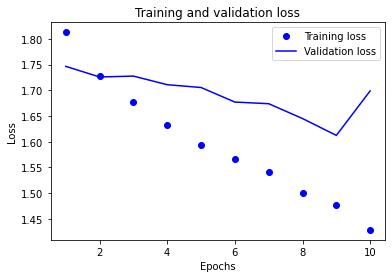

In [106]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

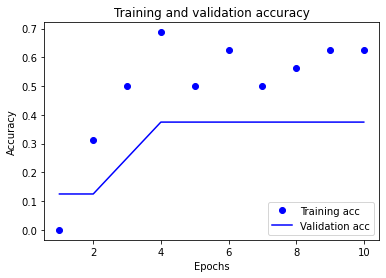

In [107]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [151]:
import numpy as np
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [160]:
###regression training
from re import X
from keras import models
from keras import layers
from keras import regularizers

def build_model():
    model = models.Sequential()
    # add l1 and l2 regulations
    model.add(layers.Dense(32, kernel_regularizer = regularizers.l1_l2(l1 = 1e-5, l2 = 1e-4),
                            #bias_regularizer=regularizers.l2(1e-4),
                            #activity_regularizer=regularizers.l2(1e-5),
                            activation='relu',
                            input_shape=(padded_train.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    #try different optimizers
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [161]:
import numpy as np
k=4
num_val_samples = len(X_train) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([X_train[:i * num_val_samples], X_train[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],y_train[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    model.fit(padded_train, train_labels,
            epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(padded_test, test_labels, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [162]:
num_epochs = 200
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate([X_train[:i * num_val_samples],X_train[(i + 1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([y_train[:i * num_val_samples],y_train[(i + 1) * num_val_samples:]],axis=0)
    model = build_model()
    history = model.fit(padded_train, train_labels,
                        validation_data=(padded_test, test_labels),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [163]:
#build the history of successive mean k-fold validation scores
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

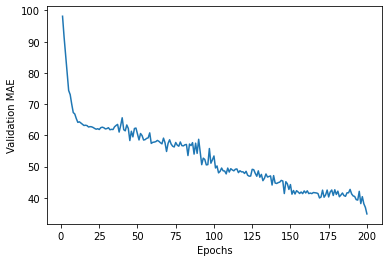

In [164]:
#plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

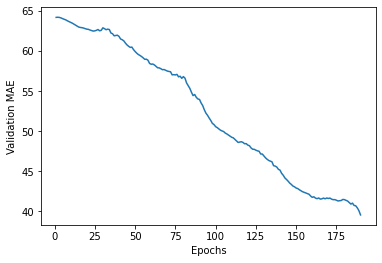

In [165]:
#plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [167]:
#training the final model
model = build_model()
model.fit(padded_train, train_labels, epochs = 80, batch_size = 16, verbose = 0)
test_mae_score, test_mae_score = model.evaluate (padded_test, test_labels) 

test_mae_score

/Users/yihuiliu_/opt/anaconda3/envs/anly590/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 17ms/step - loss: 531.8258 - mae: 18.5624


18.56237030029297